In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import probplot
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
import pickle

In [18]:
import warnings
warnings.simplefilter('ignore')

# Содержание

* [1.Глобальные переменные](#global)
* [2.Используемые функции](#definitions)
* [3.Анализ данных и проверка гипотез](#analysis)
    * [3.1.Анализ категориальных признаков](#cat_analysis)
    * [3.2.Анализ непрерывных признаков](#num_analysis)
    * [3.3.Анализ признакового пространства](#corr_analysis)
    * [3.4.Заполнение пропущенных значений](#fill_miss)
    * [3.5.Анализ целевой переменной](#target_analysis)
    * [3.6.Ключевые гипотезы и выводы](#outcomes)
* [4.Получение бэйзлайна](#baseline)
    * [4.1.Логистическая регрессия](#logit)
    * [4.2.Дерево решений](#decision_tree)
    * [4.3.Ансамблевые алгоритмы](#ensemble)
* [5.Создание новых признаков](#new)
* [6.Настройка гиперпараметров](#tune)
    * [6.1.RandomForest](#rf)
    * [6.2.Light GBM](#lgbm)
    * [6.3.AdaBoost](#adaboost)
* [7.Ensemble modelling](#ensmod)

In [333]:
train_df = pd.read_csv('train.csv', encoding='utf-8')
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
test_df = pd.read_csv('test.csv', encoding='utf-8')

In [566]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [592]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Is_home_ownership               2500 non-null object
Annual Income                   1987 non-null float64
Is_stable_employment            2500 non-null object
Is_tax_liens                    2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Is_credit_problems              2500 non-null float64
Months since last delinquent    1142 non-null float64
Is_bancruptcies                 2497 non-null float64
Is_debt_consolidation           2500 non-null object
Is_longterm_credit              2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

# <left>1. Глобальные переменные<a class="anchor" id="global"></a><left>

Список категориальных переменных.

In [6]:
cat_features = [col for col in train_df.columns if train_df[col].dtype == 'object']

Список непрерывных переменных.

In [7]:
nom_features = [col for col in train_df.columns if train_df[col].dtype == 'float64']

Список потенциально категориальных переменных.

In [8]:
categorize = ['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']

Финальный список непрерывных переменных.

In [6]:
num_features = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent',
                'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

Финальный список категориальных переменных.

In [7]:
new_cat = ['Is_home_ownership', 'Is_stable_employment', 'Is_tax_liens', 'Is_credit_problems',
           'Is_debt_consolidation', 'Is_longterm_credit']

Кроссвалидация.

In [8]:
cv = StratifiedKFold(n_splits=3, random_state=43, shuffle=True)

# <left>2. Используемые функции<a class="anchor" id="definitions"></a><left>

График оценки статистической частоты.

In [62]:
def estimate_frequency_plot(data, variables, font_scale, figsize, style):
    sns.set(font_scale=font_scale)
    plt.figure(figsize=figsize)
    plt.style.use(style)

    for i, feature in enumerate(variables):
        counts = data[feature].value_counts()

        plt.subplot(3,2,i+1)    
        plt.title(feature)
        sns.barplot(counts.index, counts.values)

График оценки доли переменной в разрезе целевой переменной.

In [63]:
def estimate_share_plot(data, variables, font_scale, figsize, style, hue):
    sns.set(font_scale=font_scale)
    plt.figure(figsize=figsize)
    plt.style.use(style)

    for i, feature in enumerate(variables):

        plt.subplot(3,2,i+1)
        plt.title(feature)
        sns.countplot(x=feature, hue=hue, data=data)

График доверительного интервала с расчётом.

In [64]:
def confidence_interval_plot(data, variables, font_scale, figsize, style, capsize, target):
    sns.set(font_scale=font_scale)
    plt.figure(figsize=figsize)
    plt.style.use(style)
    
    for i, feature in enumerate(variables):
       
        plt.subplot(4,3,i+1)  
        sns.pointplot(x=target, y=feature, data=data, capsize=capsize)
        plt.title('95 процентный доверительный интервал для' + ' ' + feature);

График оценки распределения.

In [65]:
def qq_plot(data, variables, figsize):
    plt.figure(figsize=figsize)
    
    for i, feature in enumerate(variables):
        
        plt.subplot(4,3,i+1)
        probplot(data[feature], dist='norm', plot=plt);
        plt.title('Распределение' + ' ' + feature);

Расчёт критерия согласия Хи-квадрат Пирсона.

In [66]:
def calc_chi2(data, target, values, feature, category1, category2, aggfunc, treshold):
    table = data.loc[data[feature].isin([category1, category2]),[values, feature, target]]
    table[values] = table.index
    chi2_table = table.pivot_table(values = values,
                                   index=feature, 
                                   columns=target, 
                                   aggfunc=aggfunc)
    chi2, p, dof, expected = chi2_contingency(chi2_table, correction=False)
    
    if p < treshold:
        print(f'Разделение на категории {category1} и {category2} для {feature} статистически значимо')
    else:
        print(f'Разделение на категории {category1} и {category2} для {feature} статистически незначимо')

Расчёт критерия Шапиро-Уилка.

In [67]:
def calc_shapiro(data, variables, treshold, target):
    for feature in data[variables]:
        feature_with_target = data[[feature, target]]
        feature_ = feature_with_target[feature]
        stat, p = shapiro(feature_)
        
        if p < treshold:
            print(f'Гипотеза о нормальном распределении для {feature} отвергается')
        else:
            print(f'Гипотеза о нормальном распределении для {feature} принимается')

Проверка гипотез о зависимости признаков с целевой переменной.

In [68]:
def dependency_hypo(data, variables, treshold, target):
    
    for feature in data[variables]:
        feature_with_target = data[[feature,target]]
        feature_ = feature_with_target[feature]
        stat, p = shapiro(feature_)
    
        feature_0 = feature_[feature_with_target[target] == 0]
        feature_1 = feature_[feature_with_target[target] == 1]
        
        if p < treshold:
            stat, p_= mannwhitneyu(feature_0, feature_1)

            if p_< treshold:
                print(f'Гипотеза о равенстве мат.ожиданий для {feature} отвергается')
            else:
                print(f'Гипотеза о равенстве мат.ожиданий для {feature} принимается')
                  
        else:
            stat, p_= ttest_ind(feature_0, feature_1)

            if p_< treshold:
                print(f'Гипотеза о равенстве мат.ожиданий для {feature} отвергается')
            else:
                print(f'Гипотеза о равенстве мат.ожиданий для {feature} принимается')

График для оценки корреляций.

In [12]:
def cor_plot(data, method):
    plt.figure(figsize = (14,14))

    sns.set(font_scale=1)
    sns.heatmap(data.corr(method).round(2), annot=True, linewidths=.5, cmap='coolwarm')
    plt.title('Матрица корреляций');

Отчёт по оценке модели.

In [9]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

Отчёт по коэффициентам логита.

In [401]:
def get_coef_report(data, model):
    count = 0
    for column in data.columns:
        print((np.round(model.coef_[0][count], decimals=3)), column)
        count += 1

Балансировка классов.

In [14]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

Функции для создания новых признаков.

In [55]:
#квадраты непрерывных признаков
def parabolize(data, power, features):
    for i in features:
        name = i + 'power'
        data[name] = np.power(data[i], power)

In [16]:
#логарифмы непрерывных признаков
def get_log(data, features):
    for i in features:
        name = i + 'log'
        data[name] = np.log(data[i])

График кривых валидации и обучения.

In [17]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

График для оценки калибровки классов.

In [31]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

График feature importance.

In [10]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

# <left>3. Анализ данных и проверка гипотез<a class="anchor" id="analysis"></a><left>

## 3.1. Анализ категориальных признаков<a class="anchor" id="cat_analysis"></a>

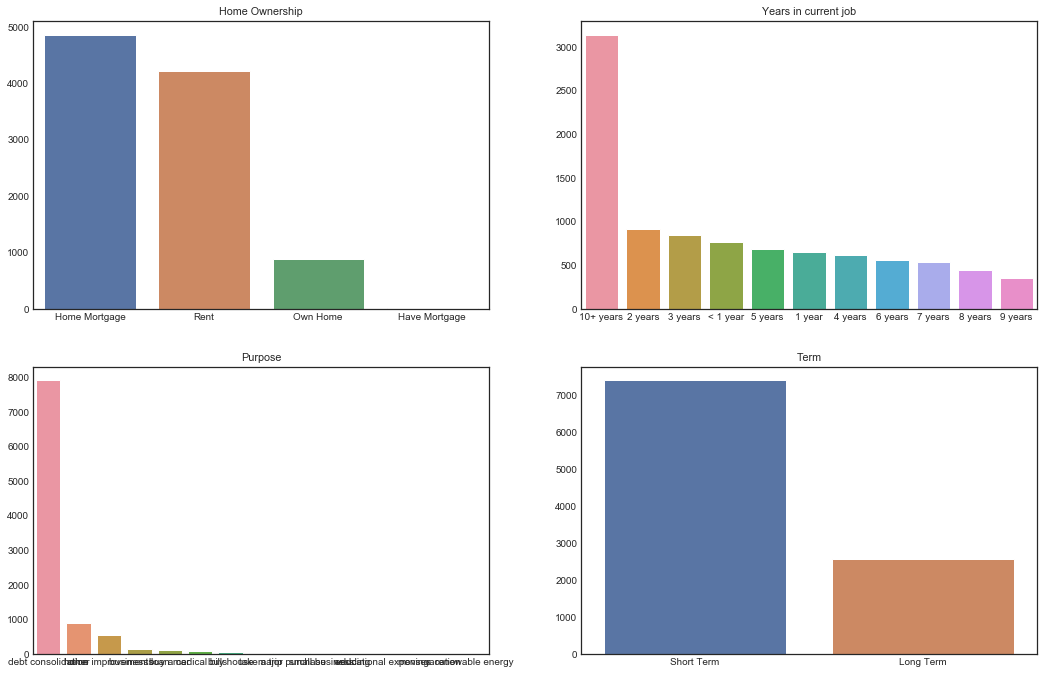

In [21]:
estimate_frequency_plot(df, cat_features, 0.9, (18,18), 'seaborn-white')

Кроме переменной "срок кредита", категорий довольно много. Для всех переменных характерен дисбаланс категорий,
т.е. одни категории встречаются очень часто, а другие - довольно редко. Проведу оценку этих признаков в разрезе целевой переменной, чтобы понять оптимальное количество групп, на которые стоит разбивать эти признаки. Для этого буду использовать 
критерий хи-квадрат Пирсона на уровне значимости 0.05.

Метод позволяет оценить статистическую значимость различий двух или нескольких относительных показателей (частот, долей).

$x^n = (x_1, .. , x_n), \: x^n \in X$<br>

$H_0:$ Эмпирические (наблюдаемые) и теоретические (ожидаемые) частоты согласованы <br>
$H_1: \: H_0 \:$ неверна<br>

$$\chi^2 = \sum_{i=1}^K \frac{(O_i - E_i)^2}{E_i}$$
$O$ (Observed) - наблюдаемые частоты<br> 
$E$ (Expected) - ожидаемые частоты<br>
$K$ - количество оцениваемых частот

$\chi^2 \sim \chi^2(\mathit{df})$

Сопоставляемые группы должны быть независимыми, то есть критерий хи-квадрат не должен применяться при сравнении наблюдений "до-после" или связанных пар. Аналог для зависимых выборок - *тест Мак-Немара* или *Q-критерий Кохрена* для сравнения трех и более групп.

Если в ячейке меньше 10 наблюдений, применяется *поправка Йетса*. 

Если меньше 5, то вместо хи-квадрат используется *точный тест Фишера*.

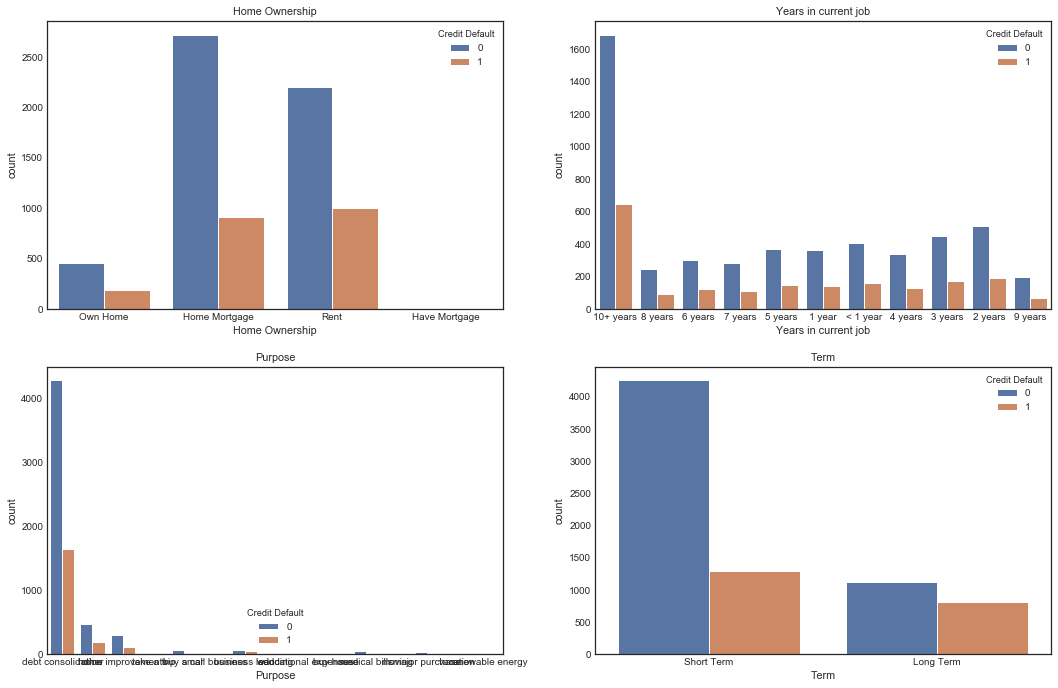

In [22]:
estimate_share_plot(train_df, cat_features, 0.9, (18,18), 'seaborn-white', 'Credit Default')

Визуальная оценка графиков позволяет сделать следующие гипотезы.

Для переменной **Home Ownership** доля целевого признака во всех категориях примерно одинакова. Такая же картина
наблюдается для переменной **Years in current job**, а также для переменной **Purpose**. Для переменной **Term** доля целевой переменной в категориях не одинакова. Теперь проверю эти гипотезы, используя расчётный тест.

In [130]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Home Ownership', category1='Own Home', 
          category2='Rent', aggfunc='count')

'Разделение на категории Own Home и Rent для Home Ownership статистически незначимо'

In [136]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Home Ownership', category1='Rent', 
          category2='Home Mortrage', aggfunc='count')

'Разделение на категории Rent и Home Mortrage для Home Ownership статистически незначимо'

In [137]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Years in current job', category1='10+ years', 
          category2='1 year', aggfunc='count')

'Разделение на категории 10+ years и 1 year для Years in current job статистически незначимо'

In [144]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Purpose', category1='debt consolidation', 
          category2='home improvements', aggfunc='count')

'Разделение на категории debt consolidation и home improvements для Purpose статистически незначимо'

In [131]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Term', category1='Short Term', 
          category2='Long Term', aggfunc='count')

'Разделение на категории Short Term и Long Term для Term статистически значимо'

Расчётные значения подтвердили гипотезы. На уровне значимости 0.05 у нас нет оснований отвергать нулевую гипотезу только для переменной **Short Term**. Только для срока кредита разбиение на категории статистически значимо.

В остальных переменных оставлю только одну категорию

*   **Is_home_ownership** - наличие права собственности на жилую площадь
*   **Is_stable_employment** - заёмщик на текущем месте работы более 10 лет
*   **Is_debt_consolidation** - кредит берётся на покрытие другого кредита
*   **Is_longterm_credit** - кредит береётся на длительный срок

In [334]:
train_df.rename(columns={'Home Ownership': 'Is_home_ownership',
               'Years in current job': 'Is_stable_employment',
               'Purpose': 'Is_debt_consolidation'}, 
               inplace=True)

In [335]:
test_df.rename(columns={'Home Ownership': 'Is_home_ownership',
               'Years in current job': 'Is_stable_employment',
               'Purpose': 'Is_debt_consolidation'}, 
               inplace=True)

In [336]:
train_df['Is_home_ownership'] = train_df['Is_home_ownership'].replace({'Home Mortgage': 1, 'Own Home': 1, 
                                                                     'Have Mortgage': 1, 'Rent': 0})
test_df['Is_home_ownership'] = test_df['Is_home_ownership'].replace({'Home Mortgage': 1, 'Own Home': 1, 
                                                                     'Have Mortgage': 1, 'Rent': 0})

In [337]:
train_df['Is_stable_employment'] = train_df['Is_stable_employment'].replace({'2 years': 1, '3 years': 1, '< 1 year': 1,
                                                                            '5 years': 1, '1 year': 1, '4 years': 1,
                                                                            '6 years': 1, '7 years': 1, '8 years': 1,
                                                                            '9 years': 1, '10+ years': 0})
test_df['Is_stable_employment'] = test_df['Is_stable_employment'].replace({'2 years': 1, '3 years': 1, '< 1 year': 1,
                                                                            '5 years': 1, '1 year': 1, '4 years': 1,
                                                                            '6 years': 1, '7 years': 1, '8 years': 1,
                                                                            '9 years': 1, '10+ years': 0})

In [338]:
train_df['Is_debt_consolidation'] = train_df['Is_debt_consolidation'].replace({'other': 1, 'home improvements': 1, 
                                                                              'business loan': 1, 'buy a car': 1,
                                                                              'medical bills': 1, 'major purchase': 1,
                                                                              'take a trip': 1, 'buy house': 1,
                                                                              'small business': 1, 'wedding': 1,
                                                                              'moving': 1, 'educational expenses': 1,
                                                                              'vacation': 1, 'renewable energy': 1,
                                                                              'debt consolidation': 0})
test_df['Is_debt_consolidation'] = test_df['Is_debt_consolidation'].replace({'other': 1, 'home improvements': 1, 
                                                                              'business loan': 1, 'buy a car': 1,
                                                                              'medical bills': 1, 'major purchase': 1,
                                                                              'take a trip': 1, 'buy house': 1,
                                                                              'small business': 1, 'wedding': 1,
                                                                              'moving': 1, 'educational expenses': 1,
                                                                              'vacation': 1, 'renewable energy': 1,
                                                                              'debt consolidation': 0})

In [339]:
train_df.rename(columns={'Term': 'Is_longterm_credit'}, 
               inplace=True)
test_df.rename(columns={'Term': 'Is_longterm_credit'}, 
               inplace=True)

In [340]:
train_df['Is_longterm_credit'] = train_df['Is_longterm_credit'].replace({'Short Term': 1, 'Long Term': 0})
test_df['Is_longterm_credit'] = test_df['Is_longterm_credit'].replace({'Short Term': 1, 'Long Term': 0})

In [341]:
train_df['Is_home_ownership'] = train_df['Is_home_ownership'].astype('str')
train_df['Is_stable_employment'] = train_df['Is_stable_employment'].astype('str')
train_df['Is_debt_consolidation'] = train_df['Is_debt_consolidation'].astype('str')
train_df['Is_longterm_credit'] = train_df['Is_longterm_credit'].astype('str')

In [342]:
test_df['Is_home_ownership'] = test_df['Is_home_ownership'].astype('str')
test_df['Is_stable_employment'] = test_df['Is_stable_employment'].astype('str')
test_df['Is_debt_consolidation'] = test_df['Is_debt_consolidation'].astype('str')
test_df['Is_longterm_credit'] = test_df['Is_longterm_credit'].astype('str')

## 3.2. Анализ непрерывных признаков<a class="anchor" id="num_analysis"></a>

Построим доверительные интервалы для средних значений каждой из двух групп и сравним их.

Доверительный интервал - это вид интервальной оценки, которая задаёт числовые границы, в которых с определённой вероятностью находится истинное значение оцениваемого параметра.

**Порядок расчета доверительного интервала (для мат. ожидания)**

1. Задать уровень достоверности (confidence level), $\alpha = 95\% = 0.95$
2. Найти по таблице Z-оценок или рассчитать коэффициент достоверности (confidence coefficient) - $ Z_{\alpha/2}$, для $\alpha = 0.95, Z_{\alpha/2} = 1.96$
3. Рассчитать доверительный интервал (confidence interval):

$$ CI = \overline{x} \pm Z_{\alpha/2} \frac{\sigma}{\sqrt{n}}$$<br>
где $ \bar{x}$ - выборочное среднее, $ \sigma$ - стандартное отклонение, $ n$ - размер выборки

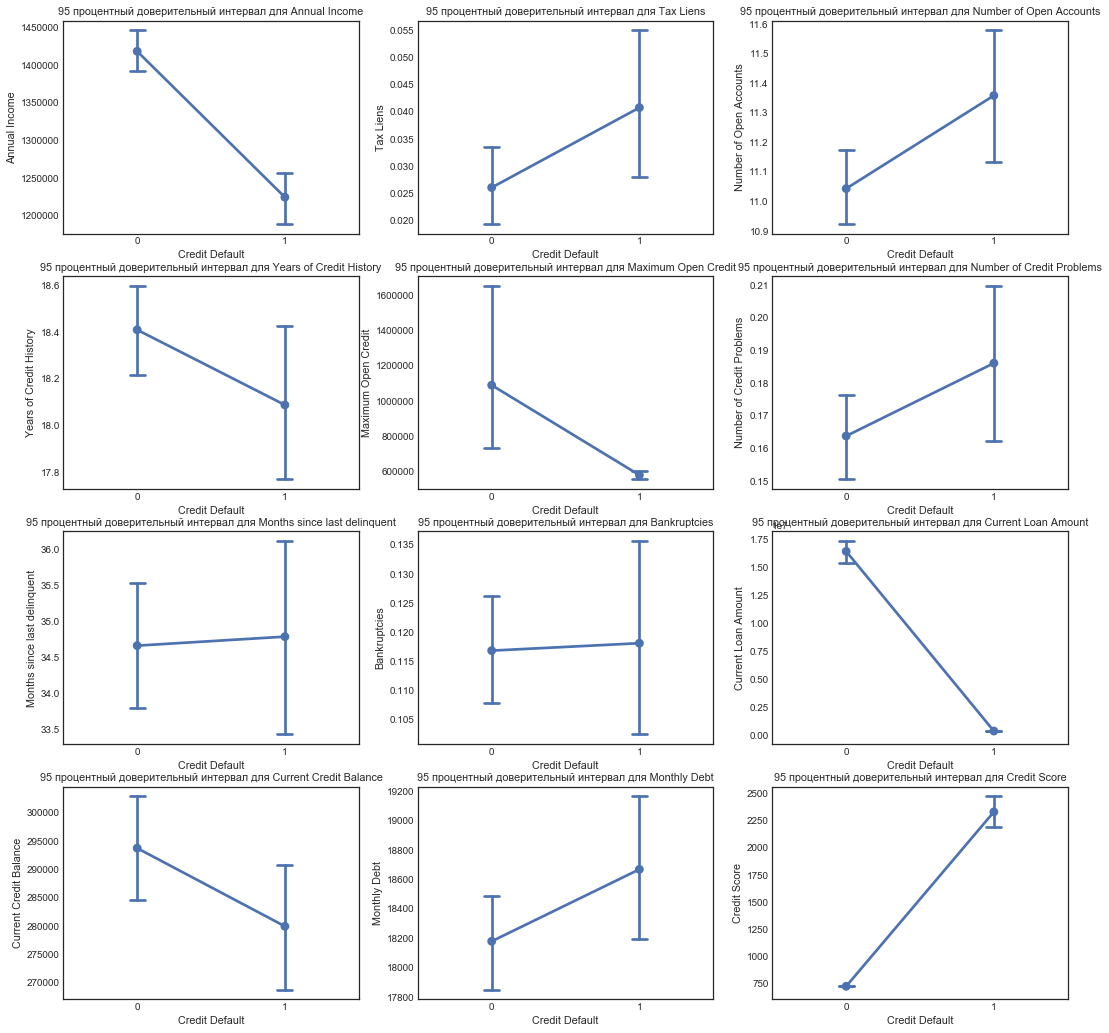

In [174]:
confidence_interval_plot(data=train_df, variables=nom_features, 
                         font_scale=0.9, figsize=(18,18), 
                         style='seaborn-white', capsize=.1,
                         target='Credit Default');

На 95 процентном доврительном интервале средние значения для переменных **Months since last delinquent** и **Bankruptcies** 
практически одинаково. Для остальных непрерывных признаков выборочные средние различаются. Это может говорить о том, что
эти две переменные **не оказывают функциональной зависимости на целевую переменную**. Проверим эту гипотезу при помощи анализа
распределений.

Оценим распределение визуально при помощи qq-plot.

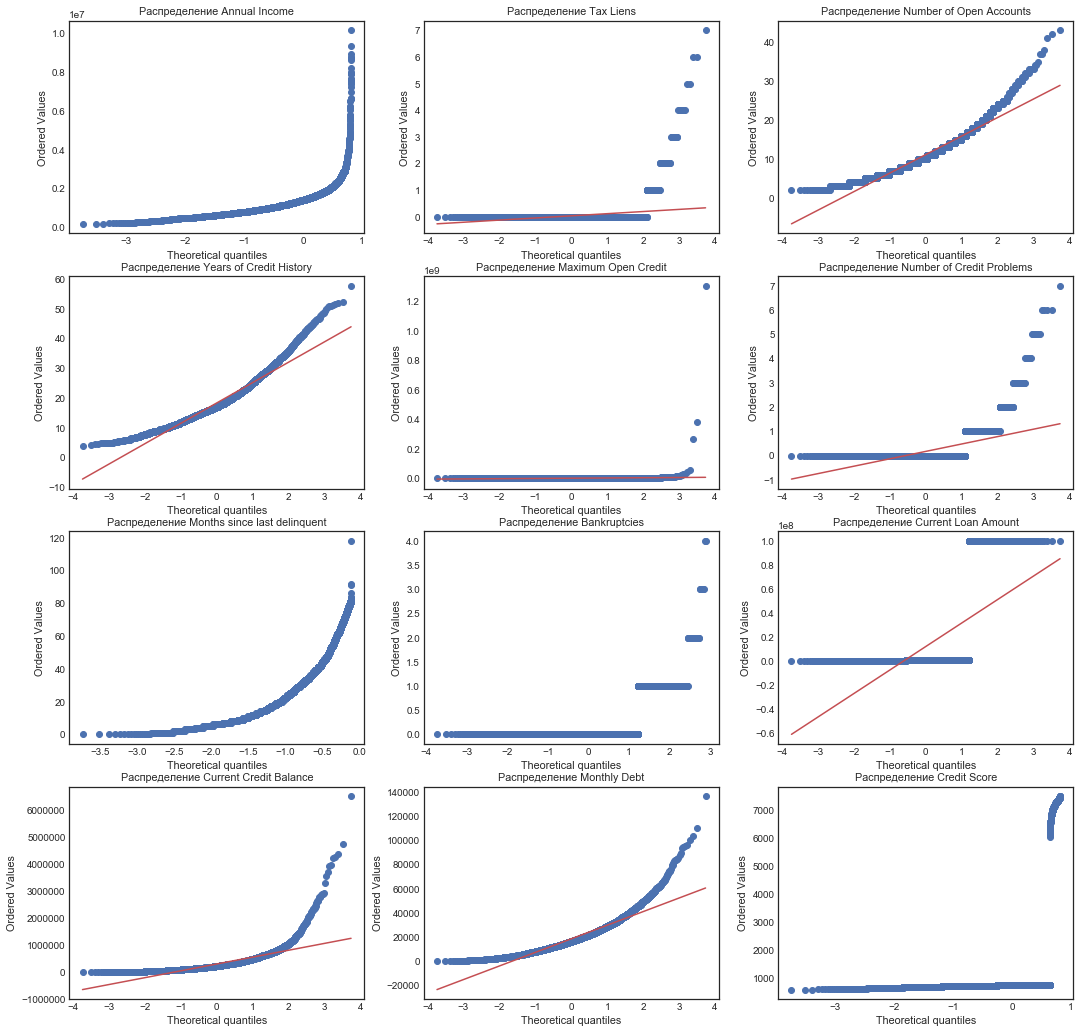

In [52]:
qq_plot(train_df, nom_features, figsize=(18,18))

Из графиков функций распределения видно, что для некоторых переменных функции распределения выглядят ступенчатыми. С большой
долей вероятности эти переменные являются категриальными: 

* **Tax Liens**
* **Bancruptcies**
* **Number of credit problems**

Также отметим довольно странные выбросы в переменной **Credit Score**.

Проверю гипотезу о нормальном распределении при помощи критерия Шапиро-Уилка.

Данный критерий проверяет гипотезу о том, что некоторая случайная величина имеет нормальное распределение (распределение Гаусса). Необходимость проверять случайную величину на "нормальность", обусловлена тем, что многие статистические критерии и  аналитические методы из мат. статистики ориентированы на выборки из нормально распределённых случайных величин и перед их использованием необходимо убедиться в том, что закон распределения приближен к нормальному.

$x^n = (x_1, .. , x_n), \: x^n \in X$<br>

$H_0: \: X \sim N(\mu, \sigma^2)$<br>
$H_1: \: H_0 \: неверна$<br>

$$W = \frac{(\sum_{i=1}^n a_i x_i)^2}{\sum_{i=1}^n (x_i - \bar{x})^2} $$

In [29]:
calc_shapiro(data=train_df, variables=nom_features, 
             treshold=0.05, target='Credit Default')

Гипотеза о нормальном распределении для Annual Income принимается
Гипотеза о нормальном распределении для Tax Liens отвергается
Гипотеза о нормальном распределении для Number of Open Accounts отвергается
Гипотеза о нормальном распределении для Years of Credit History отвергается
Гипотеза о нормальном распределении для Maximum Open Credit отвергается
Гипотеза о нормальном распределении для Number of Credit Problems отвергается
Гипотеза о нормальном распределении для Months since last delinquent принимается
Гипотеза о нормальном распределении для Bankruptcies принимается
Гипотеза о нормальном распределении для Current Loan Amount отвергается
Гипотеза о нормальном распределении для Current Credit Balance отвергается
Гипотеза о нормальном распределении для Monthly Debt отвергается
Гипотеза о нормальном распределении для Credit Score принимается


Проведу оценку возможной функциональной зависимости при помощи t-критерия Стьюдента для признаков с нормальным распредлением и критерий Манна-Уитни для признаков с распределением, отличного от нормального.

Критерий Стьюдента* — общее название для статистических тестов, в которых статистика критерия имеет распределение Стьюдента.<br> Наиболее часто данные критерии применяются для проверки равенства средних значений (мат. ожиданий) в двух выборках.

$ x_1^{n_1} = (x_{11}, .. , x_{1{n_1}}), \: x_1^{n_1} \in X_1, \: X_1 \sim \mathrm{N}(\mu_1, \sigma_1^2), \sigma_1 неизвестна$<br>
$ x_2^{n_2} = (x_{21}, .. , x_{2{n_2}}), \: x_2^{n_2} \in X_2, \: X_2 \sim \mathrm{N}(\mu_2, \sigma_2^2), \sigma_2 неизвестна$<br>

$H_0: \: \mu_1 = \mu_2$<br>
$H_1: \: \mu_1 \ne \mu_2\text{ либо }\mu_1 < \mu_2\text{ либо }\mu_1 > \mu_2$<br>

$$T(x_1^{n_1}, x_2^{n_2}) = \frac{\overline{x_1} \: - \: \overline{x_2}}{\sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}}$$
$T(x_1^{n_1}, x_2^{n_2}) \sim \mathrm{t }(\mathit{df}=n_1+n_2-2)$

In [31]:
dependency_hypo(data=train_df, variables=nom_features, treshold=0.05, target='Credit Default')

Гипотеза о равенстве мат.ожиданий для Annual Income принимается
Гипотеза о равенстве мат.ожиданий для Tax Liens отвергается
Гипотеза о равенстве мат.ожиданий для Number of Open Accounts отвергается
Гипотеза о равенстве мат.ожиданий для Years of Credit History отвергается
Гипотеза о равенстве мат.ожиданий для Maximum Open Credit отвергается
Гипотеза о равенстве мат.ожиданий для Number of Credit Problems принимается
Гипотеза о равенстве мат.ожиданий для Months since last delinquent принимается
Гипотеза о равенстве мат.ожиданий для Bankruptcies принимается
Гипотеза о равенстве мат.ожиданий для Current Loan Amount отвергается
Гипотеза о равенстве мат.ожиданий для Current Credit Balance принимается
Гипотеза о равенстве мат.ожиданий для Monthly Debt отвергается
Гипотеза о равенстве мат.ожиданий для Credit Score принимается


Для переменных **Months since last delinquent** и **Bankruptcies** результаты по доверительным интервалам совпадают с расчётными статистическими критериями. Однако, расчётные критерии показали, что для переменных **Annual Income** и **Credit Score** нет функциональной зависимости с целевой переменной. Это возможно из-за довольно высокой жёсткости критерия Шапиро-Уилка. Если применить менее жёсткий критерий Колмогорова-Смирнова, результаты могут отличаться.

Воспользуемся снова критерием хи-квадрат для потенциально новых категориальных переменных.

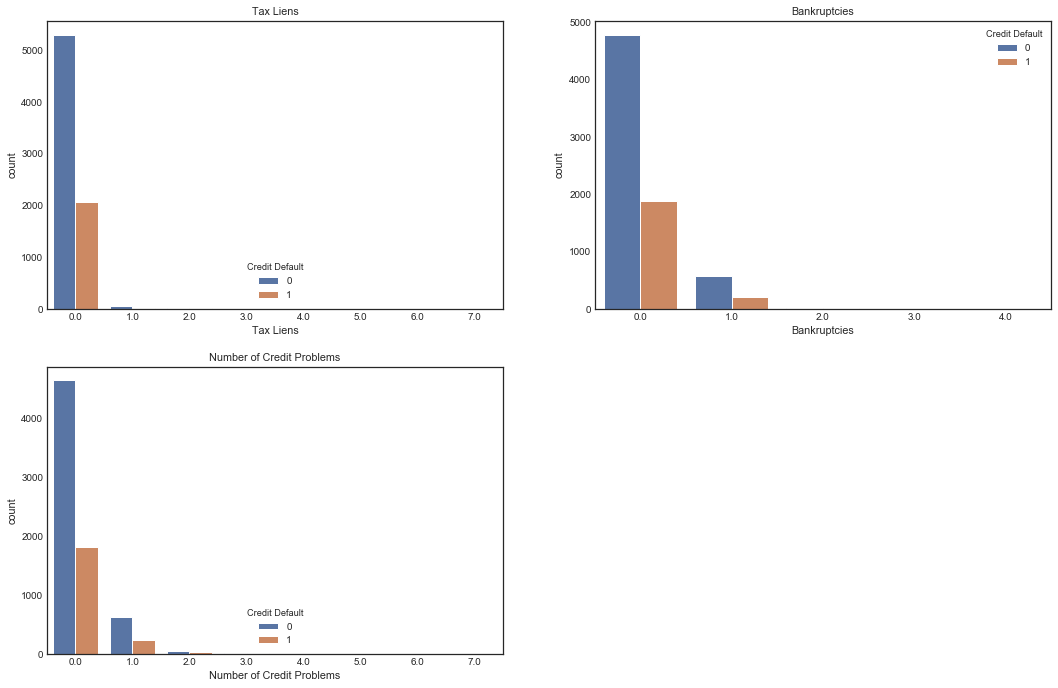

In [36]:
estimate_share_plot(train_df, categorize, 0.9, (18,18), 'seaborn-white', 'Credit Default')

Для переменной **Tax Liens** крайне мало значений больше нуля. Аналогично для двух других переменных. Для **Bancruptcies**  и **Number of Credit Problems** очень мало значений больше 1. Проверю расчётно гипотезы о значимости доли разбиения переменных по  категориям для **Bancruptcies** и **Number of Credit Problems**. Визуально можно отметить, что разделение более чем на одну группу статистически незначимо.

In [41]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Number of Credit Problems', category1='0.0', 
          category2='1.0', aggfunc='count', treshold=0.05)

Разделение на категории 0.0 и 1.0 для Number of Credit Problems статистически незначимо


In [43]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Bankruptcies', category1='0.0', 
          category2='1.0', aggfunc='count', treshold=0.05)

Разделение на категории 0.0 и 1.0 для Bankruptcies статистически незначимо


Так и есть. На уровне значимости 0.05 есть основания отвергать нулевую гипотезу, поэтому разобью эти переменные на одну категорию. Однако, скорее всего, эти переменные окажутся не сильно значимыми, поскольку есть довольно сильный перекос в сторону
одного конкретного значения. Да и доверительные интервалы намекают на это.

*   **Is_tax_liens** - есть налоговый залог.
*   **Is_bancruptcies** - факт наличия банкроства.
*   **Is_credit_problems** - факт наличия проблем с выплатой кредита.

In [343]:
train_df.rename(columns={'Tax Liens': 'Is_tax_liens',
               'Bankruptcies': 'Is_bancruptcies',
               'Number of Credit Problems': 'Is_credit_problems'}, 
               inplace=True)

In [344]:
test_df.rename(columns={'Tax Liens': 'Is_tax_liens',
               'Bankruptcies': 'Is_bancruptcies',
               'Number of Credit Problems': 'Is_credit_problems'}, 
               inplace=True)

In [345]:
train_df['Is_tax_liens'] = train_df['Is_tax_liens'].replace({0.0: 1, 1.0: 0, 2.0: 0,
                                                            3.0: 0, 4.0: 0, 5.0: 0,
                                                            6.0: 0, 7.0: 0})

In [346]:
test_df['Is_tax_liens'] = test_df['Is_tax_liens'].replace({0.0: 1, 1.0: 0, 2.0: 0,
                                                            3.0: 0, 4.0: 0, 5.0: 0,
                                                            6.0: 0, 7.0: 0})

In [347]:
train_df['Is_bancruptcies'] = train_df['Is_bancruptcies'].replace({0.0: 1, 1.0: 0, 2.0: 0,
                                                            3.0: 0, 4.0: 0, 5.0: 0,
                                                            6.0: 0})
test_df['Is_bancruptcies'] = test_df['Is_bancruptcies'].replace({0.0: 1, 1.0: 0, 2.0: 0,
                                                            3.0: 0, 4.0: 0, 5.0: 0})

In [348]:
train_df['Is_credit_problems'] = train_df['Is_credit_problems'].replace({0.0: 1, 1.0: 0, 2.0: 0,
                                                            3.0: 0, 4.0: 0, 5.0: 0,
                                                            6.0: 0, 7.0: 0})
test_df['Is_credit_problems'] = test_df['Is_credit_problems'].replace({0.0: 1, 1.0: 0, 2.0: 0,
                                                            3.0: 0, 4.0: 0, 5.0: 0,
                                                            6.0: 0, 7.0: 0})

## 3.3. Анализ признакового пространства<a class="anchor" id="corr_analysis"></a>

Проверим наличие мультиколлинеарности при помощи корреляции Пирсона для непрерывных признаков и корреляции Спирмэна для
категориальных признаков.

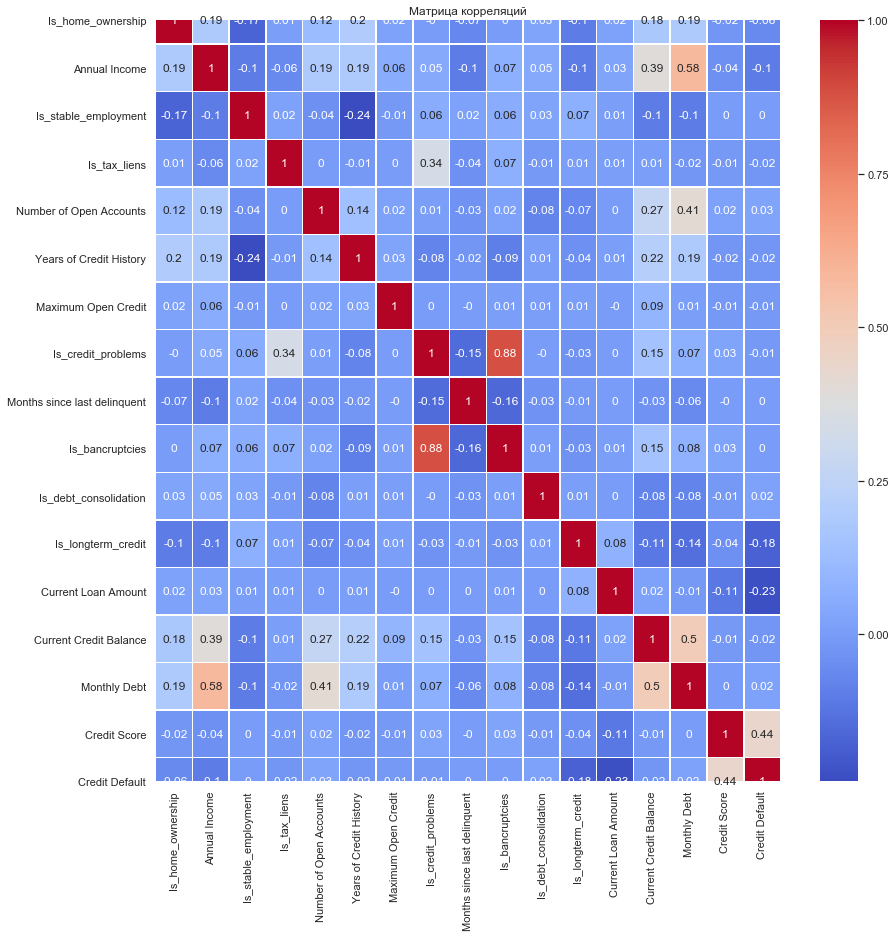

In [86]:
cor_plot(data=train_df, method='pearson');

Признаки практически не имеют линейной зависимости друг с другом, наблюдается частичная мультиколлинеарность. Имеющиеся признаки довольно уникальны.

## 3.4. Заполнение пропущенных значений<a class="anchor" id="fill_miss"></a>

Пропуски в непрерывных признаках заполню медианой, чтобы избежать выбросов.

In [349]:
train_df.loc[train_df['Annual Income'].isna(), 'Annual Income'] = train_df['Annual Income'].median()
train_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = train_df['Months since last delinquent'].median()
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score'] = train_df['Credit Score'].median()

In [350]:
test_df.loc[test_df['Annual Income'].isna(), 'Annual Income'] = train_df['Annual Income'].median()
test_df.loc[test_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = train_df['Months since last delinquent'].median()
test_df.loc[test_df['Credit Score'].isna(), 'Credit Score'] = train_df['Credit Score'].median()

Пропуски в категориальных переменных заполню модой.

In [351]:
train_df.loc[train_df['Is_stable_employment'].isna(), 'Is_stable_employment'] = train_df['Is_stable_employment'].mode()[0]
train_df.loc[train_df['Is_bancruptcies'].isna(), 'Is_bancruptcies'] = train_df['Is_bancruptcies'].mode()[0]

In [352]:
test_df.loc[test_df['Is_bancruptcies'].isna(), 'Is_bancruptcies'] = test_df['Is_bancruptcies'].mode()[0]

Сохраню предобработанный датасет.

In [353]:
train_df.to_csv('train_processed.csv', encoding='utf-8', index=False)
test_df.to_csv('test_processed.csv', encoding='utf-8', index=False)

## 3.5. Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

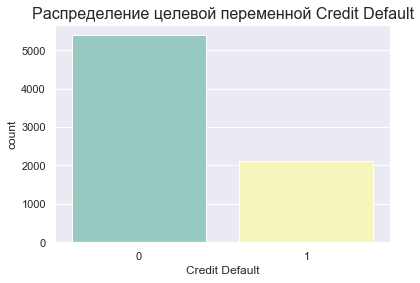

In [92]:
sns.countplot(x='Credit Default', data = train_df, palette="Set3")
plt.title('Распределение целевой переменной Credit Default', fontsize=16);

In [93]:
train_df['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

Классы не сбалансированы. Балансировка классов может сыграть полезную роль в построении модели.

## 3.6. Ключевые гипотезы и выводы<a class="anchor" id="outcomes"></a>

- Переменные **Home Ownership**, **Years in current job**, **Purpose** не обладают стастической значимостью разделения 
на предлагаемые категории на уровне значимости 0.05. Переменная **Term** доля целевой переменной в предлагаемых группах не одинакова.
Целесообразно оставить только одну группу, применив one hot encoding.
- С вероятностью 95% переменные **Months since last delinquent** и **Bankruptcies** не являются значимыми для построения модели.
- Изначально отмеченные как непрерывные, переменные **Tax Liens**, **Bancruptcies** и **Number of credit problems** оказались
категориальными, поскольку обладают ступенчатым распределением. Каждая из этих переменных приведена к категориальным с одной 
группой путём one hot encoding. **Tax Liens** и **Number of credit problems** скорее всего, окажутся слабо значимыми для построения
модели.
- Парный коэффициент корреляции Пирсона показал незначительную частичную мультиколлинеарность и очень слабую линейную связь между признаками и целевой переменной. Возможно, есть нелинейные взимосвязи.
- Балансировка классов может помочь в улучшении качества модели
- Имеет смысл в качестве бэйзлайна построить логистическую регрессию и дерево решений для финальной оценки взаимосвязей
и проверки результатов стастических гипотез из раздела 3.

# 4. Получение бэйзлайна<a class="anchor" id="baseline"></a>

In [2]:
train_df = pd.read_csv('train_processed.csv', encoding='utf-8')
train_df.head()

,Is_home_ownership,Annual Income,Is_stable_employment,Is_tax_liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Is_credit_problems,Months since last delinquent,Is_bancruptcies,Is_debt_consolidation,Is_longterm_credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,1,482087.0,NaN,1.0,11.0,26.3,685960.0,0.0,32.0,0.0,0,1,99999999.0,47386.0,7914.0,749.0,0
1,1,1025487.0,0.0,1.0,15.0,15.3,1181730.0,1.0,32.0,1.0,0,0,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,1.0,1.0,11.0,35.0,1182434.0,1.0,32.0,1.0,0,1,99999999.0,308389.0,13651.0,742.0,0
3,1,805068.0,1.0,1.0,8.0,22.5,147400.0,0.0,32.0,0.0,0,1,121396.0,95855.0,11338.0,694.0,0
4,0,776264.0,1.0,1.0,13.0,13.6,385836.0,0.0,32.0,1.0,0,1,125840.0,93309.0,7180.0,719.0,0


In [3]:
train_df.loc[train_df['Is_stable_employment'].isna(), 'Is_stable_employment'] = train_df['Is_stable_employment'].mode()[0]

In [4]:
df_norm = train_df.copy()

Отмасштабируем непрерывные признаки, поскольку используем линейную модель.

In [11]:
scaler = StandardScaler()

df_norm[num_features] = scaler.fit_transform(df_norm[num_features])

In [12]:
df_norm.head()

,Is_home_ownership,Annual Income,Is_stable_employment,Is_tax_liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Is_credit_problems,Months since last delinquent,Is_bancruptcies,Is_debt_consolidation,Is_longterm_credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,1,-1.114304,1.0,1.0,-0.026674,1.133645,-0.016174,0.0,-0.083484,0.0,0,1,2.760520,-0.762772,-0.872085,-0.218932,0
1,1,-0.396190,0.0,1.0,0.788223,-0.428528,0.014763,1.0,-0.083484,1.0,0,0,-0.363620,0.330781,0.004909,-0.227276,1
2,1,-0.758385,1.0,1.0,-0.026674,2.369181,0.014807,1.0,-0.083484,1.0,0,1,2.760520,0.058379,-0.391034,-0.223799,0
3,1,-0.687478,1.0,1.0,-0.637847,0.593985,-0.049781,0.0,-0.083484,0.0,0,1,-0.368118,-0.610282,-0.584980,-0.257174,0
4,0,-0.725543,1.0,1.0,0.380774,-0.669954,-0.034902,0.0,-0.083484,1.0,0,1,-0.367978,-0.618292,-0.933631,-0.239791,0


Организуем отложенную выборку.

In [13]:
y = df_norm['Credit Default']
X = df_norm.drop('Credit Default', axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, 
                                                    random_state=43) #lets be special

## 4.1. Логистическая регрессия<a class="anchor" id="logit"></a>

In [19]:
lr = LogisticRegression(penalty='l1',
                       tol=1e-8, #критерий останова
                        C=1e-2, #немножко регуляризации
                       class_weight='balanced', 
                       random_state=43,
                       max_iter=400, #количество итераций
                       n_jobs=-1,
                      )

In [20]:
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4075
           1       0.52      0.52      0.52      1550

    accuracy                           0.74      5625
   macro avg       0.67      0.67      0.67      5625
weighted avg       0.74      0.74      0.74      5625

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1312
           1       0.55      0.51      0.53       563

    accuracy                           0.73      1875
   macro avg       0.67      0.67      0.67      1875
weighted avg       0.72      0.73      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1077  235
1                276  287


Посмотрим на коэффициенты при переменных, значимые и незначимые признаки.

In [402]:
get_coef_report(X, lr)

0.0 Is_home_ownership
-0.204 Annual Income
0.0 Is_stable_employment
0.0 Is_tax_liens
0.006 Number of Open Accounts
0.0 Years of Credit History
0.0 Maximum Open Credit
0.0 Is_credit_problems
0.0 Months since last delinquent
0.0 Is_bancruptcies
0.0 Is_debt_consolidation
-0.333 Is_longterm_credit
-0.845 Current Loan Amount
0.0 Current Credit Balance
0.037 Monthly Debt
0.674 Credit Score


Наилучшую модель логистической регрессии удалось построить, применив l1 регуляризацию. Модель подтвердила статистические гипотезы из раздела 3. Также можно заметить, что не занулились коэффициенты с максимальным различием среднего значения в разрезе целевой переменной. В целом, модель получилась довольно консервативной.

In [403]:
with open('logit.pickle', 'wb') as f:
    pickle.dump(lr, f)

## 4.2. Дерево решений<a class="anchor" id="decision_tree"></a>

In [20]:
features = ['Is_home_ownership',
 'Annual Income',
 'Is_stable_employment',
 'Is_tax_liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Is_credit_problems',
 #'Months since last delinquent',
 #'Is_bancruptcies',
 'Is_debt_consolidation',
 'Is_longterm_credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [429]:
y = train_df['Credit Default']
X = train_df[features].drop('Credit Default', axis=1)

In [430]:
dt = DecisionTreeClassifier(max_features='sqrt',random_state=43, 
                            class_weight='balanced', min_impurity_split=1e-3,
                            criterion='gini')

In [431]:
dt_params = {'max_depth': np.arange(6, 15), #максимальная глубина дерева
             'min_samples_leaf': np.arange(1, 5),
            'max_leaf_nodes': [100, 500, 1000]}

In [432]:
%%time

gs = GridSearchCV(dt, dt_params, scoring='f1', n_jobs=-1, cv=cv)
gs.fit(X, y)

Wall time: 5.69 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=43, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=0.001,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=43,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': array([ 6,  7,  8,  9, 

In [433]:
gs.best_score_

0.5151031431913519

Наилучшее значение метрики для дерева получилось без переменных **Months since last delinquent** и **Is_bancruptcies**, что
подтвердило результат проверки статистических гипотез. Значение целевой метрики оказалось чуть ниже, чем
в логистической регрессии, однако эта модель не такая консервативная. Между остальными признаками(друг с другом) и с целевой
переменной подтвердилось наличие нелинейной взаимосвязи.

## 4.3. Ансамблевые алгоритмы<a class="anchor" id="ensemble"></a>

Теперь прогоним на дефолтных гиперпараметрах следующие алгоритмы:
   * **Случайный лес**
   * **Многослойный перцептрон**
   * **Различные реализации градиентного бустинга**

In [711]:
y = train_df['Credit Default']
X = train_df[features].drop('Credit Default', axis=1)

In [713]:
%%time

random_state = 18
classifiers = []

classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(xgb.XGBClassifier(random_state=random_state))
classifiers.append(lgbm.LGBMClassifier(random_state=random_state))
classifiers.append(catb.CatBoostClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X, y = y, scoring = 'f1', cv = cv, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":[
"RandomForest", "GradientBoosting","MultipleLayerPerceptron", "AdaBoost", "XGB", "LGBM", "CatBoost"]})

Wall time: 18.2 s


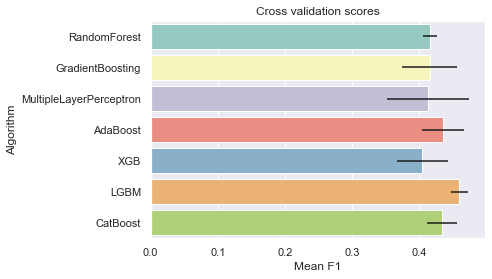

In [714]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean F1")
g = g.set_title("Cross validation scores")

Все алгоритмы, кроме XGBoost показали приблизительно одинаковый результат.

# 5. Создание новых признаков<a class="anchor" id="new"></a>

Поскольку мы подтвердили наличие нелинейной функциональной зависимости между признаками и целевой переменной, создам новые признаки:
    - Квадраты непрерывных переменных
    - Логарифмы непрерывных переменных

Квадраты.

In [172]:
parabolize(train_df, 2, num_features)

Логарифмы.

In [173]:
get_log(train_df, num_features)

In [174]:
train_df.to_csv('train_features.csv', encoding='utf-8', index=False)

# 6. Настройка гиперпараметров<a class="anchor" id="tune"></a>

In [21]:
train_df = pd.read_csv('train_features.csv', encoding='utf-8')
train_df.head()

,Is_home_ownership,Annual Income,Is_stable_employment,Is_tax_liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Is_credit_problems,Months since last delinquent,Is_bancruptcies,...,Credit Scorepower,Annual Incomelog,Number of Open Accountslog,Years of Credit Historylog,Maximum Open Creditlog,Months since last delinquentlog,Current Loan Amountlog,Current Credit Balancelog,Monthly Debtlog,Credit Scorelog
0,1,482087.0,1.0,1.0,11.0,26.3,685960.0,0.0,32.0,0.0,...,561001.0,13.085880,2.397895,3.269569,13.438575,3.465736,18.420681,10.766082,8.976389,6.618739
1,1,1025487.0,0.0,1.0,15.0,15.3,1181730.0,1.0,32.0,1.0,...,543169.0,13.840678,2.708050,2.727853,13.982490,3.465736,12.487364,12.886570,9.818637,6.602588
2,1,751412.0,1.0,1.0,11.0,35.0,1182434.0,1.0,32.0,1.0,...,550564.0,13.529709,2.397895,3.555348,13.983086,3.465736,18.420681,12.639117,9.521568,6.609349
3,1,805068.0,1.0,1.0,8.0,22.5,147400.0,0.0,32.0,0.0,...,481636.0,13.598682,2.079442,3.113515,11.900905,3.465736,11.706813,11.470592,9.335915,6.542472
4,0,776264.0,1.0,1.0,13.0,13.6,385836.0,0.0,32.0,1.0,...,516961.0,13.562248,2.564949,2.610070,12.863168,3.465736,11.742767,11.443672,8.879055,6.577861


Результат немногим лучше логистической регресии.

## 6.1. Light GBM<a class="anchor" id="lgbm"></a>

В LightGBM применяется Gradient-based One-Side Sampling(GOSS). Ключевая идея этой техники заключается в том, что на каждой
эпохе обучения выбирается наиболее значимый - с максимально возможным градиентом, т.е. таким значением градиента, который
наиболее сильно влияет на минимизацию функции потерь. На каждой эпохе обучения из общего количества объектов выбираются только
те объекты, который имеют максимальный градиент плюс с остального количества некоторый рандомный процент. 
Лист с более высоким градиентом/ошибкой используется для дальнейшего роста в LGBM. В итоге, мы не рассчитываем значение 
градиента на всей выборке(а, значит, скорость обучения будет пониже) и делаем subsample 
объектов. В целом, это довольно похоже на мини батч реализацию стохастического градиентного спуска.

Основное предположение, сделанное здесь, состоит в том, что образцы с обучающими экземплярами с небольшими градиентами имеют меньшую ошибку обучения и уже хорошо обучены. Чтобы сохранить такое же распределение данных, при вычислении прироста информации GOSS вводит постоянный множитель для экземпляров данных с небольшими градиентами. Таким образом, GOSS обеспечивает хороший баланс между уменьшением количества экземпляров данных и сохранением точности изученных деревьев решений.

Настроим гиперпараметры следующим образом:
   - 1-й шаг. Поработаем с общей сложностью модели, т.е. с гиперпараметрами, отвечающими за регуляризацию: **max_depth**,
        **num_leaves(2^max_depth-1)**, **lambda_l1**, **lambda_l2**.Исходя из гипотезы раздела 4, глубина должна быть  минимальной, следовательно, количество листьев тоже должно быть небольшим. Дополнительно можно поработать с **bagging_fraction**, который отвечает за долю выборки, участвующей в обучении, **min_data_in_leaf** и **feature_fraction**, отвечающим за
        минимальное количество признаков в листе при разбиении.
   - 2-й шаг. Поработаем со скоростью обучения(**learning_rate**) и количеством итераций(**num_iterations**). 
    Сначала найдём наилучшее максимальное значение num_iterations, а learning_rate сделаем наилучшим минимально возможным
    (исходя из ключевой идеи LGBM).
    
Также можно обозначить список категориальных переменных.

Для калибровки вероятности будем использовать дополнительное сэмлирование или подбор по порогу - пересчение всех трёх кривых 
по метрикам.

In [22]:
for feature in new_cat:
    train_df[feature] = train_df[feature].astype('int32')

In [23]:
y = train_df['Credit Default']
X = train_df.drop('Credit Default', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5250, 34), (2250, 34), (5250,), (2250,))

In [28]:
%%time

model_lightgbm = lgbm.LGBMClassifier(random_state=43, 
                                     boosting_type='dart',
                                     metric='logloss',
                                     silent=False, 
                                     scoring='f1',
                                     learning_rate=0.07, 
                                     max_depth=3, 
                                     min_data_in_leaf=15,
                                     num_leaves=5, 
                                     num_iterations=100, 
                                     is_unbalance=True,
                                     data_random_seed=17, 
                                     feature_fraction=0.95)

model_lightgbm.fit(X_train, y_train, categorical_feature=new_cat)

y_train_pred = model_lightgbm.predict(X_train)
y_test_pred = model_lightgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      3771
           1       0.55      0.53      0.54      1479

    accuracy                           0.74      5250
   macro avg       0.68      0.68      0.68      5250
weighted avg       0.74      0.74      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1616
           1       0.54      0.53      0.54       634

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1330  286
1                298  336
Wall time: 259 ms


Посомтрим на кривые валидации и обучения.

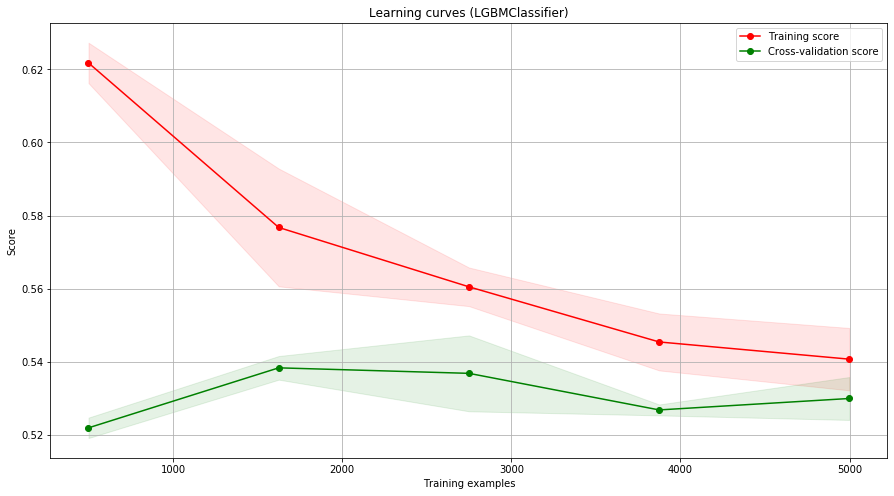

In [193]:
show_learning_curve_plot(model_lightgbm, X, y)

Оценим порог вероятности.

In [29]:
y_test_proba = model_lightgbm.predict_proba(X_test)[:, 1]

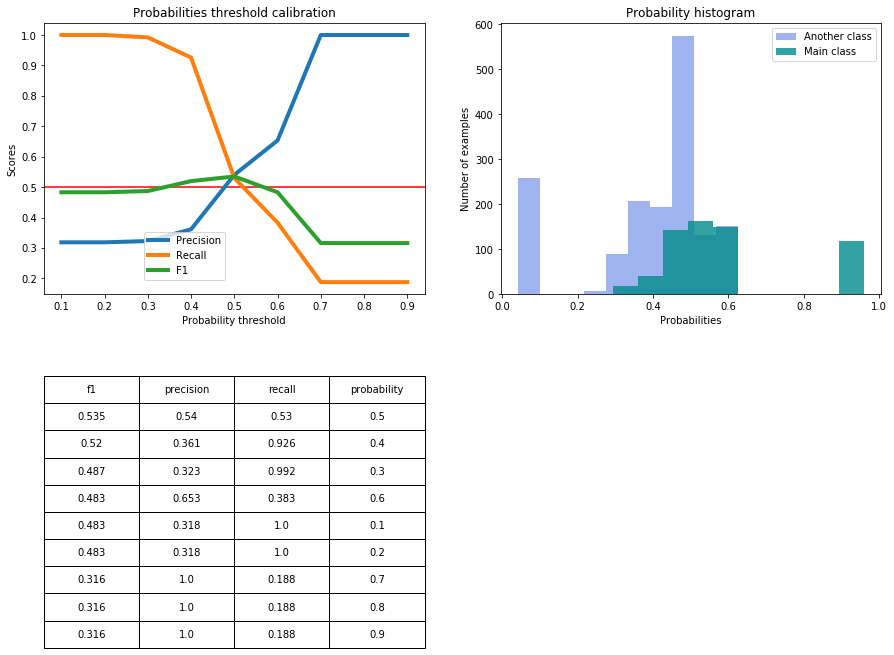

In [32]:
show_proba_calibration_plots(y_test_proba, y_test)

Отберём признаки по feature_importance.

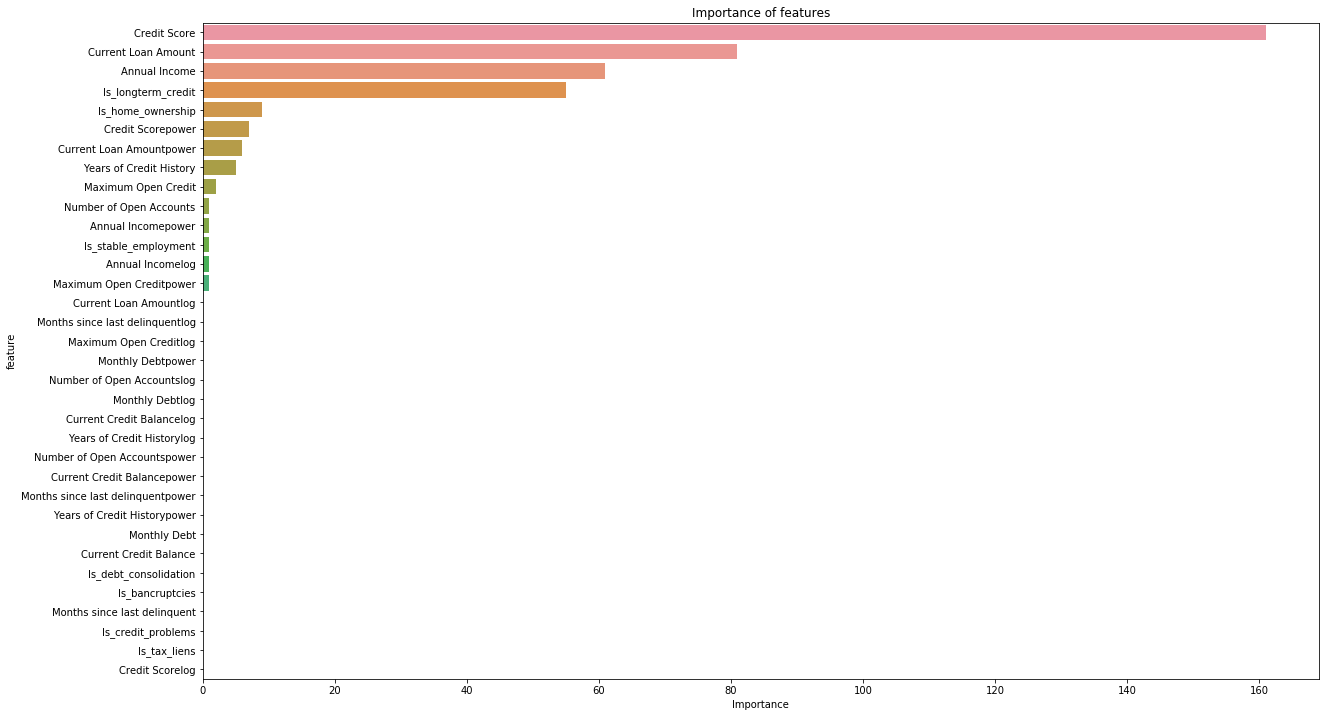

In [33]:
important_features_top = show_feature_importances(X_train.columns, model_lightgbm.feature_importances_, get_top=12)

In [34]:
%%time

model_lightgbm = lgbm.LGBMClassifier(random_state=43, 
                                     boosting_type='dart',
                                     metric='logloss',
                                     silent=False, 
                                     scoring='f1',
                                     learning_rate=0.07, 
                                     max_depth=3, 
                                     min_data_in_leaf=15,
                                     num_leaves=5, 
                                     num_iterations=100, 
                                     is_unbalance=True,
                                     data_random_seed=17, 
                                     feature_fraction=0.95)

model_lightgbm.fit(X_train[important_features_top], y_train)

y_train_pred = model_lightgbm.predict(X_train[important_features_top])
y_test_pred = model_lightgbm.predict(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      3771
           1       0.54      0.53      0.54      1479

    accuracy                           0.74      5250
   macro avg       0.68      0.68      0.68      5250
weighted avg       0.74      0.74      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1616
           1       0.54      0.54      0.54       634

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1325  291
1                293  341
Wall time: 199 ms


Оценки практически не изменились, всё что не вошло в feature_importance можно убрать.

GOSS сработал хуже всех.Балансировка дополнительным сэмплированием привела к переобучению. Возможно, стоит сэмплировать на кроссвалидации, возможно этот метод неактуален для этой задачи. Можно оценить классификатор в целом по roc_auc. 

In [488]:
with open('model_lgbm.pickle', 'wb') as f:
    pickle.dump(model_lightgbm, f)

## 6.2. AdaBoost<a class="anchor" id="adaboost"></a>

In [35]:
X_train = X_train.replace([-np.inf, np.inf], [0, 0])
X_test = X_test.replace([-np.inf, np.inf], [0, 0])

Обучаем c отобранными признаками со случайным лесом в роли base estimator. Из base estimator стараемся делать "пеньки", а после
настраивать скорость обучения и количество листьев.

In [36]:
%%time

ada = AdaBoostClassifier(RandomForestClassifier(max_depth=1, min_samples_leaf=5, criterion='gini',
                                               min_samples_split=5, class_weight='balanced',
                                               max_leaf_nodes=80,
                                                random_state=43, n_jobs=-1),
                         algorithm='SAMME.R', random_state=43,
                        learning_rate=0.2, n_estimators=32)
ada.fit(X_train[important_features_top], y_train)

y_train_pred = ada.predict(X_train[important_features_top])
y_test_pred = ada.predict(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      3771
           1       0.52      0.55      0.54      1479

    accuracy                           0.73      5250
   macro avg       0.67      0.68      0.67      5250
weighted avg       0.74      0.73      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1616
           1       0.52      0.56      0.54       634

    accuracy                           0.73      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1285  331
1                281  353
Wall time: 13.9 s


Слегка отличаются precision и recall.

Калибровку здесь провести нельзя, поскольку алгоритм строит только разделяющую гиперплоскость.

In [491]:
with open('ada.pickle', 'wb') as f:
    pickle.dump(ada, f)

# 7. Ensemble modelling<a class="anchor" id="ensmod"></a>

In [494]:
lr = lr.fit(X_train[important_features_top], y_train)
lgbm = model_lightgbm.fit(X_train[important_features_top], y_train)
ada = ada.fit(X_train[important_features_top], y_train)

In [496]:
model0 = pd.Series(lr.predict(X_test[important_features_top]), name='lr')
model1 = pd.Series(lgbm.predict(X_test[important_features_top]), name='lgbm')
model2 = pd.Series(ada.predict(X_test[important_features_top]), name='ada')

In [497]:
ensemble_results = pd.concat([model0, model1, model2], axis=1)

Оценим взаимосвязи результатов классификации при помощи корреляции Пирсона.

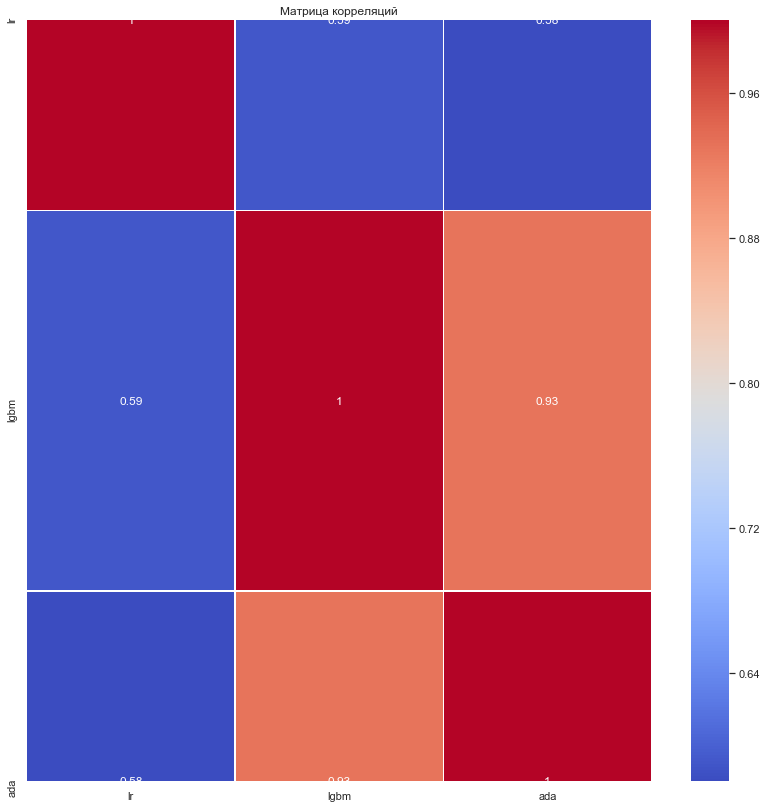

In [498]:
cor_plot(ensemble_results, method='pearson')

Довольно сильно коррелируют результаты LGBM и AdaBoost, но в целом, можно попытаться улучшить модель, поскольку есть
не очень коррелирующих результаты.

In [523]:
%%time

vote = VotingClassifier(estimators=[('lr', lr), ('lgbm', lgbm)],
                       voting='soft', #для расчёта вероятности
                       n_jobs=-1,
                       weights=[0.5, 10])

vote.fit(X_train[important_features_top], y_train)
y_train_pred = vote.predict(X_train[important_features_top])
y_test_pred = vote.predict(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      3771
           1       0.55      0.54      0.54      1479

    accuracy                           0.74      5250
   macro avg       0.68      0.68      0.68      5250
weighted avg       0.74      0.74      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1616
           1       0.53      0.54      0.54       634

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1319  297
1                294  340
Wall time: 30.8 s


Результаты практически не изменились.

Посмотрим на порог вероятности.

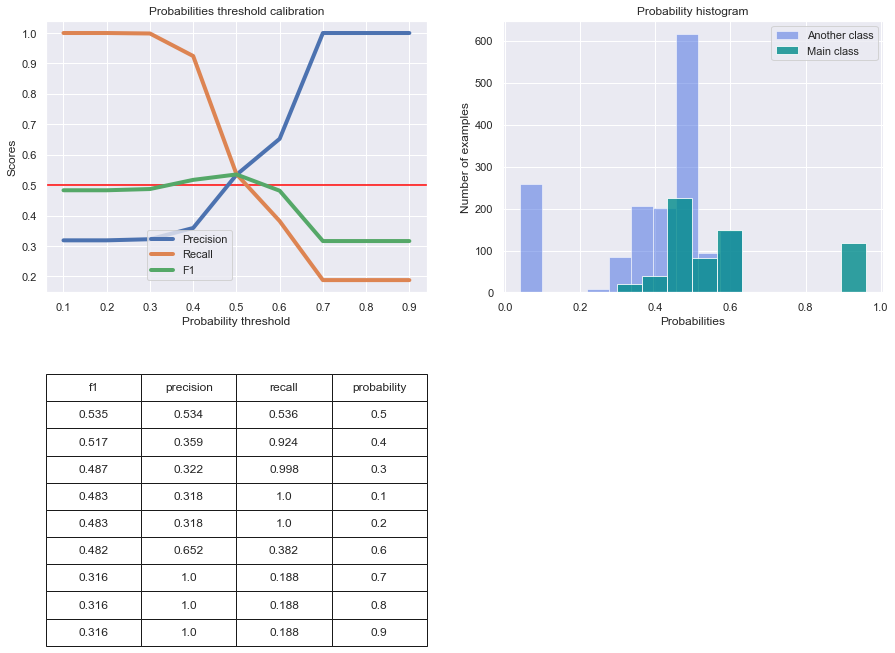

In [521]:
y_test_proba = vote.predict_proba(X_test[important_features_top])[:, 1]
show_proba_calibration_plots(y_test_proba, y_test)

В итоге выберем LGBM.

In [63]:
test_df = pd.read_csv('test_processed.csv', encoding='utf-8')
test_df.head()

,Is_home_ownership,Annual Income,Is_stable_employment,Is_tax_liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Is_credit_problems,Months since last delinquent,Is_bancruptcies,Is_debt_consolidation,Is_longterm_credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,0,1168386.0,1.0,1.0,9.0,12.5,220968.0,1.0,70.0,1.0,0,1,162470.0,105906.0,6813.0,731.0
1,0,231838.0,1.0,1.0,6.0,32.7,55946.0,1.0,8.0,1.0,1,1,78298.0,46037.0,2318.0,699.0
2,1,1152540.0,1.0,1.0,10.0,13.7,204600.0,1.0,32.0,1.0,0,1,200178.0,146490.0,18729.0,7260.0
3,1,1220313.0,0.0,1.0,16.0,17.0,456302.0,1.0,70.0,1.0,0,1,217382.0,213199.0,27559.0,739.0
4,1,2340952.0,1.0,1.0,11.0,23.6,1207272.0,1.0,32.0,1.0,0,0,777634.0,425391.0,42605.0,706.0


In [64]:
parabolize(test_df, 2, ['Credit Score', 'Annual Income', 'Current Loan Amount'])

In [65]:
model_lightgbm.fit(train_df[important_features_top], train_df['Credit Default'])
y_pred = model_lightgbm.predict(test_df[important_features_top])
is_default = pd.DataFrame(y_pred, columns=['Credit Default'])
is_default.to_csv('final_predictions.csv')